<a href="https://colab.research.google.com/github/tsido/lda-thesis/blob/main/colabs/contextual_tm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Usage of the CombinedTM is based on [Combined Topic Modeling tutorial](https://colab.research.google.com/drive/1fXJjr_rwqvpp1IdNQ4dxqN4Dp88cxO97?usp=sharing#scrollTo=-SEBG6wj9Zdu).

Calculate coherence scores for different number of topics using Combine Topic Model.


In [1]:
!pip install contextualized-topic-models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.3/784.3 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.8 MB/s eta

In [2]:
# Fetch the app store data from Google Drive
!mkdir data
!wget --no-check-certificate --output-document=data/enriched_data.csv 'https://docs.google.com/uc?export=download&id=1JIWIP_Hvzu69bCDz4Dz1xgs6sXzQXzG-'



--2023-11-14 12:58:59--  https://docs.google.com/uc?export=download&id=1JIWIP_Hvzu69bCDz4Dz1xgs6sXzQXzG-
Resolving docs.google.com (docs.google.com)... 142.251.6.101, 142.251.6.102, 142.251.6.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.6.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lrs7701amvgak2dvjodoao9g7l70rk15/1699966725000/09640189477530773141/*/1JIWIP_Hvzu69bCDz4Dz1xgs6sXzQXzG-?e=download&uuid=f74e6f06-69b7-4cae-8c32-d8bcbf11f62f [following]
--2023-11-14 12:59:04--  https://doc-04-ao-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lrs7701amvgak2dvjodoao9g7l70rk15/1699966725000/09640189477530773141/*/1JIWIP_Hvzu69bCDz4Dz1xgs6sXzQXzG-?e=download&uuid=f74e6f06-69b7-4cae-8c32-d8bcbf11f62f
Resolving doc-04-ao-docs.googleusercontent.com (doc-04-ao-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:4001

In [3]:
import pandas as pd
import numpy as np

from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.evaluation.measures import CoherenceNPMI
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
from nltk.corpus import stopwords as stop_words


In [4]:
# prepare the documents

nltk.download('stopwords')

df = pd.read_csv('data/enriched_data.csv')
descriptions = df['Description']

documents = [text.strip() for text in descriptions.values]
stopwords = list(stop_words.words("english"))
descriptions = df['Description'].str.split()

# this is used by the coherence model for context windows
coherence_docs = df['PreprocessedDescription'].str.split()

sp = WhiteSpacePreprocessingStopwords(documents, stopwords, vocabulary_size=2000)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
unpreprocessed_corpus

['Welcome to the land of fairies in this puzzle game for toddlers and kids from ages 0 to 6.',
 'An interactive fantasy adventure! It\'s a book. It\'s a game. It\'s an RPG. It\'s a Gamebook Adventure!\n\nFirst in the series of critically acclaimed interactive fantasy gamebooks in which you, the reader, control the direction of the story! Along with a realistic dice-based battle system to fight creatures, a great story and beautiful artwork, An Assassin in Orlandes will give you many hours of gamebook adventuring!\n\nSet within Orlandes City, nobles are being systematically murdered by a ruthless assassin no-one seems able to catch. Finding yourself thrust in the middle of a large conspiracy, you must make decisions that may put yourself and one other most precious to you in great danger. Can you locate the Assassin in Orlandes before it is too late?\n\n"Even though Fighting Fantasy books have nearly a 30 year lead on the recently released Gamebook Adventures, the team at Tin Man Games 

In [6]:
# we're interested in english only, so using roberta as the base contextual model
# for SBERT underneath that's underneath the CTM
tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v2")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.10/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 796 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/65 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
tp.vocab[:10]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['abc', 'abilities', 'ability', 'able', 'absolutely',
       'accelerometer', 'accept', 'access', 'accessible', 'accessories'],
      dtype=object)

In [8]:
print(unpreprocessed_corpus[:2])
print(preprocessed_documents[:2])

['Welcome to the land of fairies in this puzzle game for toddlers and kids from ages 0 to 6.', 'An interactive fantasy adventure! It\'s a book. It\'s a game. It\'s an RPG. It\'s a Gamebook Adventure!\n\nFirst in the series of critically acclaimed interactive fantasy gamebooks in which you, the reader, control the direction of the story! Along with a realistic dice-based battle system to fight creatures, a great story and beautiful artwork, An Assassin in Orlandes will give you many hours of gamebook adventuring!\n\nSet within Orlandes City, nobles are being systematically murdered by a ruthless assassin no-one seems able to catch. Finding yourself thrust in the middle of a large conspiracy, you must make decisions that may put yourself and one other most precious to you in great danger. Can you locate the Assassin in Orlandes before it is too late?\n\n"Even though Fighting Fantasy books have nearly a 30 year lead on the recently released Gamebook Adventures, the team at Tin Man Games h

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
ctm_coherence_scores = []
# TODO
# running the full range takes about an hour
number_of_topics = range(5, 50, 1)
# running this takes some ~10 mins, so doing the full range will take plenty of time
#number_of_topics = [5, 10, 15, 20, 30]
#number_of_topics = [10, 20, 30]


for i in number_of_topics:
  ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=i, num_epochs=10)
  ctm.fit(training_dataset)

  npmi = CoherenceNPMI(texts=coherence_docs, topics=ctm.get_topic_lists(10))
  ctm_coherence_scores.append(npmi.score())

ctm_coherence_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Epoch: [10/10]	 Seen Samples: [128640/128890]	Train Loss: 697.5728671704952	Time: 0:00:05.332566: : 10it [00:43,  4.36s/it]
100%|██████████| 202/202 [00:03<00:00, 64.50it/s]
Epoch: [10/10]	 Seen Samples: [128640/128890]	Train Loss: 695.8895552146494	Time: 0:00:03.559234: : 10it [00:44,  4.47s/it]
100%|██████████| 202/202 [00:03<00:00, 64.21it/s]
Epoch: [10/10]	 Seen Samples: [128640/128890]	Train Loss: 693.9369224434469	Time: 0:00:04.653077: : 10it [00:43,  4.37s/it]
100%|██████████| 202/202 [00:03<00:00, 62.87it/s]
Epoch: [10/10]	 Seen Samples: [128640/128890]	Train Loss: 692.7372536730411	Time: 0:00:05.769755: : 10it [00:43,  4.33s/it]

[-0.11277925476530701,
 -0.05241736145800465,
 -0.0489777746433139,
 -0.043120785474620664,
 -0.02185280178179931,
 -0.018856352729558813,
 -0.042126865081224145,
 0.012990071775975465,
 -0.03958604072027183,
 -0.04100575538941579,
 0.018710317330336353,
 nan,
 -0.016075383197107468,
 0.0468836888589435,
 nan,
 0.05011468148103056,
 0.019749588237503415,
 0.05573429965778673,
 0.011366575665593095,
 0.000234100952919677,
 0.060286853076382076,
 0.036146119357859975,
 0.05002697547009904,
 0.027206732730742308,
 0.02510293783436415,
 0.028258564732234773,
 0.04342830451577375,
 0.030497726166797023,
 0.04868983749531741,
 0.031071421504808322,
 nan,
 0.049412675681977616,
 0.06234468229878455,
 0.009096855369017656,
 0.0025816547903780218,
 0.04830360967693431,
 0.03876307664986259,
 0.04672823010711348,
 0.05631972724185057,
 0.02100956366065052,
 0.024725960903823486,
 0.043538488961204755,
 0.0293058343103572,
 0.016817994423046833,
 0.01100891055643921]

In [10]:
#[-0.16699919368290342,
 #-0.122910908136456,
 #-0.059639283380795834,
 #-0.0364816747927442,
 #-0.0730489805701099]

ctm_coherence_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-0.11277925476530701,
 -0.05241736145800465,
 -0.0489777746433139,
 -0.043120785474620664,
 -0.02185280178179931,
 -0.018856352729558813,
 -0.042126865081224145,
 0.012990071775975465,
 -0.03958604072027183,
 -0.04100575538941579,
 0.018710317330336353,
 nan,
 -0.016075383197107468,
 0.0468836888589435,
 nan,
 0.05011468148103056,
 0.019749588237503415,
 0.05573429965778673,
 0.011366575665593095,
 0.000234100952919677,
 0.060286853076382076,
 0.036146119357859975,
 0.05002697547009904,
 0.027206732730742308,
 0.02510293783436415,
 0.028258564732234773,
 0.04342830451577375,
 0.030497726166797023,
 0.04868983749531741,
 0.031071421504808322,
 nan,
 0.049412675681977616,
 0.06234468229878455,
 0.009096855369017656,
 0.0025816547903780218,
 0.04830360967693431,
 0.03876307664986259,
 0.04672823010711348,
 0.05631972724185057,
 0.02100956366065052,
 0.024725960903823486,
 0.043538488961204755,
 0.0293058343103572,
 0.016817994423046833,
 0.01100891055643921]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


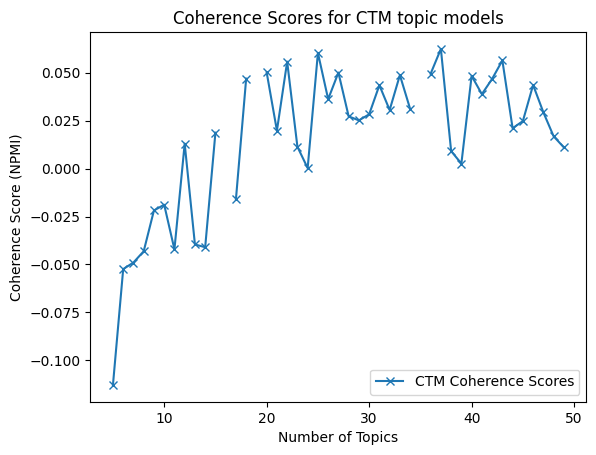

In [11]:
import matplotlib.pyplot as plt

plt.plot(
    number_of_topics,
    ctm_coherence_scores,
    marker='x',
    label='CTM Coherence Scores'
)

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (NPMI)')
plt.title('Coherence Scores for CTM topic models')
plt.legend()
plt.show()